In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py#离线
import plotly.graph_objs as go# 用来生成图形对象
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm

# Stats
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
# Reading dataset
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [2]:
display(train.head(),test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Survival : 0 = No, 1 = Yes  
Pclass : Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd   
Sex : Sex Male or Female   
Age : Age in years   
Sibsp : number of siblings / spouses aboard the Titanic 配偶    
Parch : number of parents / children aboard the Titanic 小孩     
Ticket : Ticket number   票编号   
Fare : Passenger fare   票价   
Cabin : Cabin number   船舱   
Embarked : Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton   登船口    
Type : train or test   

In [3]:
train['Type'] = 'train'
test['Type'] = 'test'
data = train.append(test)
data.shape

(1309, 13)

### 缺失值处理

In [4]:
def missing_plot(dataset, key) :
    #非空的特征统计
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    #print(len(dataset[key]) - dataset.isnull().sum())
    percentage_null = pd.DataFrame(dataset.isnull().sum()/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

passengerId不会为空，所以利用passengerId的数量来统计总的数据数目，查看缺失数据的比例
py.plot会单独生成一个html的网页，py.iplot是在notebook上即时展示

In [5]:
# Plotting 
missing_plot(data, 'PassengerId')


3/4 of Cabin are empty, we drop this variable   
32 % of target (Survived) is missing, this is test data   
20 % of Age is missing   
1 Fare is empty   
2 Embarqued are empty   

In [6]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

549死亡    342存活

In [7]:
# Plotting target (count and %)
train = data[data['Type']=='train']

#------------COUNT-----------------------

#.values.tolist()将pandas转化为list
trace = go.Bar(
        x = (train['Survived'].value_counts().values.tolist()), 
        y = ['Died', 'Survived'], 
        orientation = 'h', opacity = 0.8, 
        text=train['Survived'].value_counts().values.tolist())

layout = dict(title =  'Count of target variable',
                        autosize = False,
                        height  = 500,
                        width   = 800)
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)


In [8]:
#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['Died', 'Survived'], values = train['Survived'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['pink', 'lightblue'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of target variable',
                        autosize = True,
                        height  = 500,
                        width   = 750)
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### 3.1 define plot

In [9]:
# Defining horizontal bar plot to visualize each variable of dataset (train and test)
#水平柱状图可视化数据集的每个变量（训练和测试）
def barploth(var_select) :
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white', 'lightpink']
    trace1 = go.Bar(
        y=data[var_select].value_counts().keys().tolist(),
        x=data[var_select].value_counts().values.tolist(),
        text=data[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        orientation = 'h',
        name=str(var_select),opacity = 0.8, marker=dict(color = colors,
        line=dict(color = 'black',width=1)))

    layout = dict(autosize = True,
                  height  = 500,
                  width   = 800,
                  title =  'Total'+' '+str(var_select)+' '+'(train and test)',
                  xaxis=dict(), 
                  margin=go.layout.Margin(
                    l=50))

    fig = go.Figure(data=[trace1], layout=layout)
    py.iplot(fig)

In [10]:
# Defining bar plot to visualize each variable vs target (train)
#可视化每个变量与目标（序列）
def barplot(var_select,title) :
    S = data[data['Survived']==1]
    D = data[data['Survived']==0]
    tmp1 = S
    tmp2 = D

    color=['lightskyblue','gold']
    trace2 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='Survived',opacity = 1, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))

    trace1 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='Died', opacity = 1, marker=dict(
        color='pink',
        line=dict(color='#000000',width=1)))

    layout = dict(title = title,
                  autosize = True,
                  height  = 500,
                  width   = 800,
                  #barmode = 'stack',
                  xaxis=dict(), 
                  yaxis=dict(title= 'Count'),
                 legend=dict(x=-.1, y=1.5),
                 margin=go.layout.Margin(
                    b=30))

    fig = go.Figure(data=[trace1, trace2], layout=layout)
    py.iplot(fig)


In [11]:
# Defining pie plot to visualize each variable repartition vs target modalities : Survived or Died (train)
def plot_pie(var_select) :
    S = data[data['Survived']==1]
    D = data[data['Survived']==0]
    
    col =['Silver', 'gold','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Died passenger",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = S[var_select].value_counts().values.tolist(),
                    labels  = S[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Survived passenger" )

    layout = go.Layout(dict(title = var_select + " distribution by target ",
                            annotations = [ dict(text = "Died"+" : "+"549",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Survived"+" : "+"342",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

In [12]:
# Pandas crosstab %
#统计生存/死亡的百分比
def stats(var_select):
    stats = pd.crosstab(train['Survived'], train[var_select]).apply(lambda r: r/r.sum(), axis=0)
    return stats.style.format("{:.2%}")


In [13]:
data['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
413     NaN
414    C105
415     NaN
416     NaN
417     NaN
Name: Cabin, Length: 1309, dtype: object

In [18]:
data.loc[data.Cabin.notnull(),'Cabin'] = 1
data.loc[data.Cabin.isnull(),'Cabin'] = 0
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,train


In [19]:
barploth('Cabin')
barplot('Cabin', 'Cabin vs Survived')
plot_pie('Cabin')

### 3.2 Sex

In [20]:
# Sex EDA 
barploth('Sex')

In [21]:
stats('Sex')

Sex,female,male
Survived,,
0.0,25.80%,81.11%
1.0,74.20%,18.89%


In [22]:
barplot('Sex', 'Sex vs Survived')

In [23]:
plot_pie('Sex')

### 3.3 新特征:Title

In [24]:
# Creating variable Title
data['Title'] = data['Name']
# Cleaning name and extracting Title
for name_string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
barplot('Title', 'Title vs Survived')

Some modalities can be grouped :   
Mlle : Miss in french   
Mme : Mrs in french   
Ms : used with the last name or full name of a woman, intended as a default form of address for women regardless of marital status   
Major: Military rank   
Col: Military rank   
Dr : Academic   
Rev : Christian clergy   
Capt: Military rank   
Jonkheer : Honorific in the Low Countries denoting the lowest rank within the nobility for men   
Sir :Formal Honorific address for men   
Lady : Honorific address for men   
Don : Honorific prefix primarly used in Italy, Spain, Portugal for men   
Countness : Honorific address for women   
Dona : Honorific prefix primarly used in Italy, Spain, Portugal for women   

In [25]:
# Replacing rare titles 
mapping = {'Mlle': 'Miss', 
           'Ms': 'Miss', 
           'Mme': 'Mrs',
           'Major': 'Other', 
           'Col': 'Other', 
           'Dr' : 'Other', 
           'Rev' : 'Other',
           'Capt': 'Other', 
           'Jonkheer': 'Royal',
           'Sir': 'Royal', 
           'Lady': 'Royal', 
           'Don': 'Royal',
           'Countess': 'Royal', 
           'Dona': 'Royal'}
data.replace({'Title': mapping}, inplace=True)
titles = ['Miss', 'Mr', 'Mrs', 'Royal', 'Other', 'Master']

In [26]:
barploth('Title')

In [27]:
barplot('Title', 'Title vs Survived')

In [28]:
plot_pie('Title')

### 3.4 Age

We have seen that the Age variable was missing 263 values ( ~ 20 % of the dataset).

In [29]:
# Plotting age distribution vs target
S = data[data['Survived']==1]
D = data[data['Survived']==0]

def plot_distribution(var_select, title) :  
    tmp1 = S[var_select]
    tmp2 = D[var_select]
    
    trace0 = go.Histogram(
        x=tmp1, opacity=1, name='Survived', marker=dict(
        color='lightblue')
    )
    trace1 = go.Histogram(
        x=tmp2, opacity=1, name='Died', marker=dict(
        color='pink')
    )
    
    data = [trace0, trace1]
    layout = go.Layout(barmode='stack', title = title,
                  autosize = True,
                  height  = 500,
                  width   = 800,
                  #barmode = 'stack',
                  xaxis=dict(), 
                  yaxis=dict(title= 'Count'), 
                  yaxis2=dict(range= [-0, 75], 
                              overlaying= 'y', 
                              anchor= 'x', 
                              side= 'right',
                              zeroline=False,
                              showgrid= False, 
                              title= '% Died'
                             ),
                 legend=dict(x=-.1, y=1.5),
                 margin=go.layout.Margin(
                    b=0))
    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename = 'Density plot')

In [30]:
plot_distribution('Age', 'Age vs Survived')

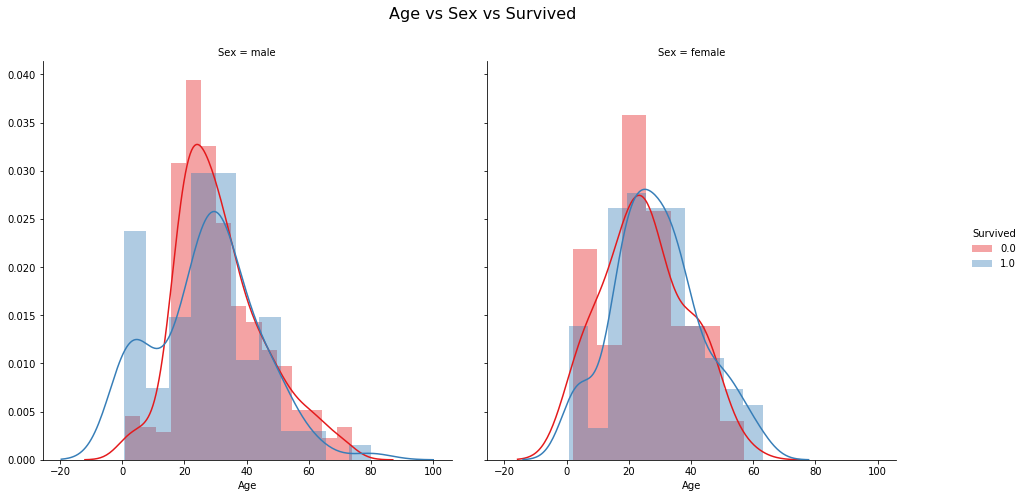

In [31]:
# Plotting age vs sex vs target
train = data[data["Type"]=="train"]
g = sns.FacetGrid(train, col="Sex", hue="Survived", palette="Set1")
g.map(sns.distplot, "Age")
g = g.add_legend()
g.fig.suptitle('Age vs Sex vs Survived', fontsize=16)
g.fig.set_size_inches(15,8)

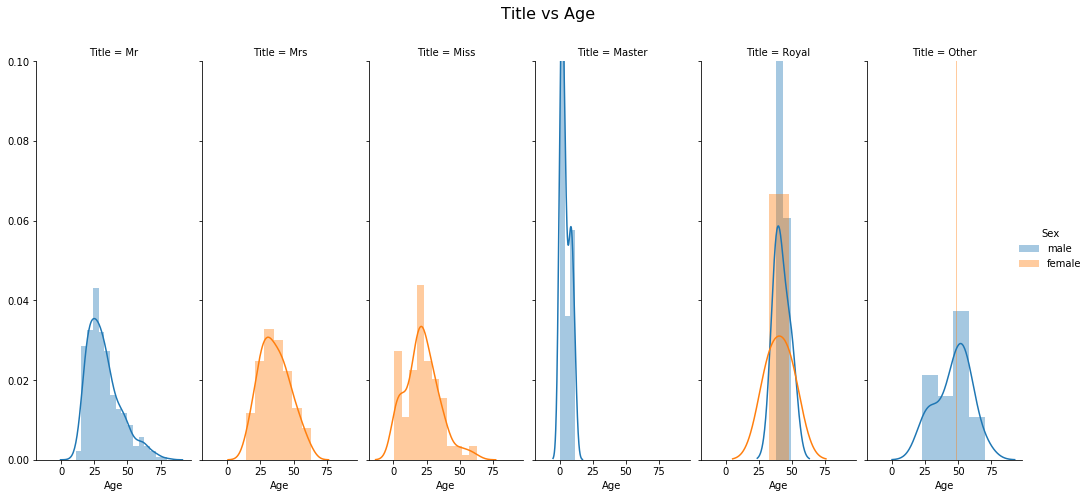

In [32]:
# Plotting title vs age vs sex
train = data[data["Type"]=="train"]
g = sns.FacetGrid(train, col="Title", hue="Sex")
g.map(sns.distplot, "Age")
g = g.add_legend()
g.set(ylim=(0, 0.1))
g.fig.suptitle('Title vs Age', fontsize=16)
g.fig.set_size_inches(15,8)

In [33]:
# Replacing missing age by median/title 
for title in titles:
    age_to_impute = data.groupby('Title')['Age'].median()[titles.index(title)]
    data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] = age_to_impute

### 3.5 新特征：Family Size

In [34]:
# EDA sibsp and parch
barplot('SibSp', 'SibSp vs Survived')
barplot('Parch', 'Parch vs Survived')

In [35]:
# Creating new feature : family size
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
data.loc[:,'FsizeD']='Alone'
data.loc[(data['Family_Size']>1),'FsizeD']='Small'
data.loc[(data['Family_Size']>4),'FsizeD']='Big'
# EDA family size
barplot('Family_Size', 'Family_size vs Survived')

In [36]:
def moscaicplot(var):
    x = 0.
    y = 0.
    width = 50.
    height = 50.
    type_list = list(data[var].unique())
    values = [len(data[data[var] == i]) for i in type_list]
    percent = [(len(data[data[var] == i])/len(data[var])*100) for i in type_list]

    normed = squarify.normalize_sizes(values, width, height)
    rects = squarify.squarify(normed, x, y, width, height)

    color_brewer =['#FF5D73','#F2D7EE','mediumturquoise','#7C7A7A','#CF5C36','lightblue','magenta']
    shapes = []
    annotations = []
    counter = 0
    for r in rects:
        shapes.append( 
            dict(type = 'rect', 
                x0 = r['x'], 
                y0 = r['y'], 
                x1 = r['x']+r['dx'], 
                y1 = r['y']+r['dy'],
                line = dict( width = 1.5, color = 'black'),
                fillcolor = color_brewer[counter]))
        annotations.append(
            dict(x = r['x']+(r['dx']/2),
                y = r['y']+(r['dy']/2),
                text = "{}<br>{}<br>{:.0f}%".format(type_list[counter], values[counter], percent[counter]), font=dict(color='black', size = 14),
                showarrow = False))
        counter = counter + 1
        if counter >= len(color_brewer):
            counter = 0

    # For hover text
    trace0 = go.Scatter(
        x = [ r['x']+(r['dx']/2) for r in rects ], 
        y = [ r['y']+(r['dy']/2) for r in rects ],
        text = [ str(v) for v in values ], 
        mode = 'text')

    layout = dict(
        autosize = True,
        height=700, 
        width=800,
        xaxis=dict(showgrid=False,zeroline=False),
        yaxis=dict(showgrid=False,zeroline=False),
        title = var +' '+ '- Distribution',
        shapes=shapes,
        annotations=annotations,
        hovermode='closest',
        font=dict(color="Black"))

    # With hovertext
    figure = dict(data=[trace0], layout=layout)
    iplot(figure, filename='squarify-treemap')


In [37]:
moscaicplot("FsizeD")

In [38]:
barplot('FsizeD', 'FsizeD vs Survived')

In [39]:
plot_pie('FsizeD')

### 3.6 处理Fare

In [40]:
data[data["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Title,Family_Size,FsizeD
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,0,S,test,Mr,1,Alone


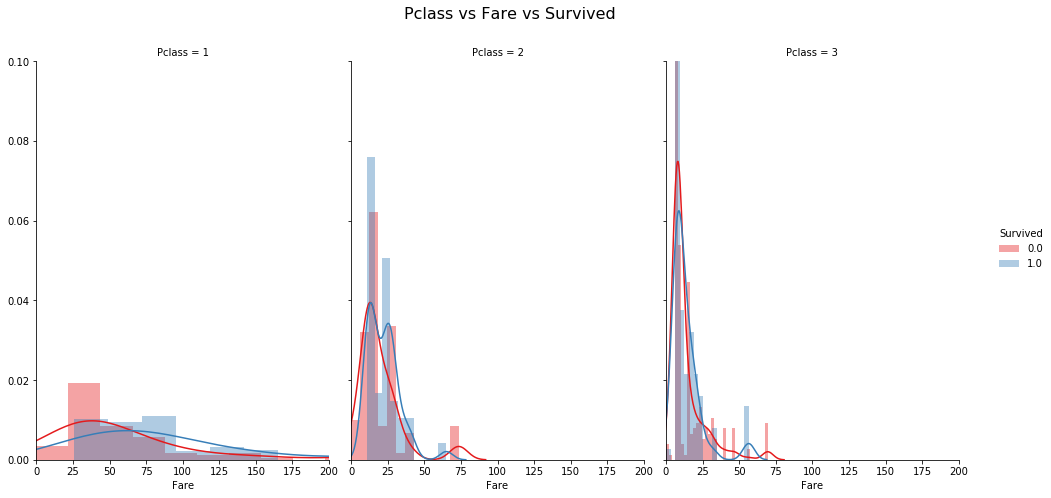

In [41]:
g = sns.FacetGrid(train, col="Pclass", hue="Survived", palette="Set1")
g.map(sns.distplot, "Fare")
g.set(ylim=(0, 0.1),xlim = (-0, 200))
g = g.add_legend()
g.fig.suptitle('Pclass vs Fare vs Survived', fontsize=16)
g.fig.set_size_inches(15,8)

In [42]:
def plot_distribution(var_select, title, bin_size) : 
    tmp1 = data[data["Pclass"] == 3]
    tmp1 = tmp1[var_select].dropna()
    hist_data = [tmp1]
    
    group_labels = [var_select]
    colors = ['gold']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, curve_type='kde', bin_size = bin_size)
    
    fig['layout'].update(title = title, autosize = True,
                        height  = 500,
                        width   = 800,annotations=[
        dict(
            x=data[data["Pclass"]==3].loc[:,"Fare"].median(),
            y=0.086,
            xref='x',
            yref='y',
            text=data[data["Pclass"]==3].loc[:,"Fare"].median(),
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40,
             font=dict(
                size=16,
                color='black'))])
    py.iplot(fig, filename = 'Density plot')
    
plot_distribution('Fare', 'Fare (Pclass = 3)',1)


In [43]:
fa = data[data["Pclass"]==3]
data['Fare'].fillna(fa['Fare'].median(), inplace = True)

### 3.7 child

In [44]:
data.loc[:,'Child']=1
data.loc[(data['Age']>=18),'Child']=0

In [45]:
barploth('Child')

In [46]:
barplot('Child', 'Child vs Survived')


In [47]:
plot_pie('Child')

### 3.8 新特征：Family_Survived

In [48]:
#是否有存活的家庭成员 不知道:0.5 有存活:1 没存活:0
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0): #有存活的为1，没有存活的为0，其余为0.5
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data.loc[data['Family_Survival']!=0.5].shape[0])


Number of passengers with family survival information: 420


In [50]:
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data[data['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 546


### 4 准备数据集

### 4.1 drop some feature

In [51]:
data = data.drop(columns = [
                            'Age', 
                            'Embarked',
                            'Name',
                            'Last_Name',
                            'Parch', 
                            'SibSp', 
                            'Ticket', 
                            'Family_Size',
                           ])
data.head()

,PassengerId,Survived,Pclass,Sex,Fare,Cabin,Type,Title,FsizeD,Child,Family_Survival
0,1,0.0,3,male,7.2500,0,train,Mr,Small,0,0.5
1,2,1.0,1,female,71.2833,1,train,Mrs,Small,0,0.5
2,3,1.0,3,female,7.9250,0,train,Miss,Alone,0,0.5
3,4,1.0,1,female,53.1000,1,train,Mrs,Small,0,0.0
4,5,0.0,3,male,8.0500,0,train,Mr,Alone,0,0.5


### 4.2 Standard scaler & dummies

In [52]:
target_col = ["Survived"]
id_dataset = ["Type"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + id_dataset]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

data = data.drop(columns = ['PassengerId'],axis = 1)
data.head(10)

,Survived,Sex,Cabin,Type,Child,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,...,Title_Mrs,Title_Other,Title_Royal,FsizeD_Alone,FsizeD_Big,FsizeD_Small,Family_Survival_0.0,Family_Survival_0.5,Family_Survival_1.0,Fare
0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,-0.503176
0,284,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,-0.503176
1,1,0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0.734809
1,283,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0.734809
2,1,0,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,-0.490126
2,282,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,-0.490126
3,1,0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0.383263
3,281,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0.383263
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,-0.487709
4,280,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,-0.487709


### 4.3 相关性图

In [53]:
def correlation_plot():
    #correlation
    correlation = data.drop(columns=['Type', 'Survived']).corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [54]:
correlation_plot()

In [55]:
# Cutting train and test
train = data[data['Type'] == 1]
test = data[data['Type'] == 0]

train = train.drop(columns = ['Type'])
test = test.drop(columns = ['Type'])

In [56]:
X = train.drop('Survived', 1)
y = train['Survived']
X_test = test
X_test = X_test.drop(columns = ['Survived'])

In [57]:
# Train_test split
random_state = 42
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = random_state)

## 5 LightGBM 使用

### 5.1 Light GBM - RandomizedSearchCV to optimise hyperparameters

In [58]:
fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_train,y_train)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
#number of combinations
n_iter = 500 

#intializing lgbm and lunching the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.8506998932898122 with params: {'colsample_bytree': 0.45579438389387933, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 103, 'min_child_weight': 0.01, 'n_estimators': 1000, 'num_leaves': 42, 'reg_alpha': 10, 'reg_lambda': 5, 'subsample': 0.6485280755329368} 


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   56.4s finished


### 5.2. Light GBM - Model performance report

In [60]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_valid, y_score) , 3)
    fpr, tpr, t = roc_curve(y_valid, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_valid, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(eval(model).feature_importances_)
    column_data   = pd.DataFrame(list(train))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients", 
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    #Cumulative gain
    pos =  np.array(pd.get_dummies(y_valid))
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_valid.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
#plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve',
                                          'Feature importance'
                                          ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                         autosize = False, 
                         height = 1500,
                         width = 800,
                         plot_bgcolor = 'black',
                         paper_bgcolor = 'black',
                         margin = dict(b = 195), 
                         font=dict(color='white')
                        )
    
    fig["layout"]["xaxis1"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["yaxis1"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')),showgrid=False)
    fig["layout"]["yaxis2"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"),showgrid=False)
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white',showgrid=False)
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white',showgrid=False)
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white',showgrid=False)
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white',showgrid=False)
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white',showgrid=False)
    fig["layout"]["xaxis6"].update(dict(color = 'white'),showgrid=False)
    fig["layout"]["yaxis6"].update(dict(color = 'white'),showgrid=False)
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)


In [61]:
%%time
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_valid)
y_score = lgbm_clf.predict_proba(X_valid)[:,1]

model_performance('lgbm_clf')

CPU times: user 972 ms, sys: 35.9 ms, total: 1.01 s
Wall time: 309 ms


### 5.4. Light GBM - Cross Validation - 5 folds - 0.8496 (+/- 0.017)

In [62]:
scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
res = []
for sc in scores:
    scores = cross_val_score(lgbm_clf, X, y, cv = 5, scoring = sc)
    #print(sc, scores)
    res.append(scores)
df = pd.DataFrame(res).T
df.loc['mean'] = df.mean()
df.loc['std'] = df.std()
df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})
trace = go.Table(
    header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['center'],
                font = dict(size = 15)),
    cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                       np.round(df['accuracy'],4),
                       np.round(df['precision'],4),
                       np.round(df['recall'],4),
                       np.round(df['f1'],4),
                       np.round(df['roc_auc'],4)],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['center'], font = dict(size = 15)))

layout = dict(width=800, height=400, title = '<b>Cross validation - 5 folds', font = dict(size = 15))
fig = dict(data=[trace], layout=layout)
py.iplot(fig, filename = 'styled_table')

In [63]:
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
lgbm_clf.fit(X, y)
y_pred = lgbm_clf.predict(X_test)

In [67]:
X_test.head(20)

,Sex,Cabin,Child,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,FsizeD_Alone,FsizeD_Big,FsizeD_Small,Family_Survival_0.0,Family_Survival_0.5,Family_Survival_1.0,Fare
0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,-0.503176
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0.734809
2,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,-0.490126
3,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0.383263
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,-0.487709
5,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,-0.479816
6,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0.359338
7,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,-0.235891
8,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,-0.428099
9,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,-0.061971


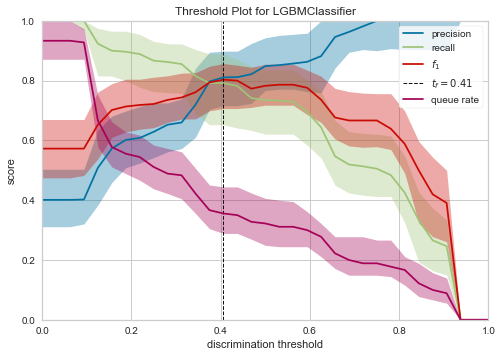

In [64]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(lgbm_clf)

visualizer.fit(X, y)  
visualizer.poof()   

In [65]:
temp = pd.DataFrame(pd.read_csv("data/test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("data/submission_lgb.csv", index = False)